In [2]:
import math
import random
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.utils.class_weight
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import pandas as pd
from imblearn.over_sampling import SMOTE 


Prepare the dataset


In [3]:
dataset=pd.read_csv("train_set.tsv",sep='\t',header=0)

#print(dataset["num_collisions"].value_counts(normalize=False))

X=dataset.iloc[:,:-2]  # : all raws :-2 slice out the last 2 columns
y=dataset.iloc[:,-2]   #just the last column

#normalized_df=(dataset-dataset.mean())/dataset.std()
Stdscaler = preprocessing.StandardScaler().fit(X)
X= Stdscaler.transform(X)
#normalized_df=(X-X.min())/(X.max()-X.min())  #between 0 and 1 (is column-wise)
#print(normalized_df.describe)
print(X.std())
random_state=12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22,random_state=random_state) #to be reproducible
print(y_train.value_counts(normalize=False))

X_train,y_train=SMOTE(k_neighbors=1).fit_resample(X_train,y_train)
print(y_train.value_counts(normalize=False))

print("Number of training samples: %d" %(X_train.shape[0]))
print("Number of test samples: %d" %(X_test.shape[0]))


1.0
0    429
1    251
2     74
3     24
4      2
Name: num_collisions, dtype: int64
1    429
0    429
2    429
3    429
4    429
Name: num_collisions, dtype: int64
Number of training samples: 2145
Number of test samples: 220


GaussianNB

Input shape reduced train: (2145, 2)
Input shape reduced test: (220, 2)


Text(0.5, 1.0, 'Training and test samples')

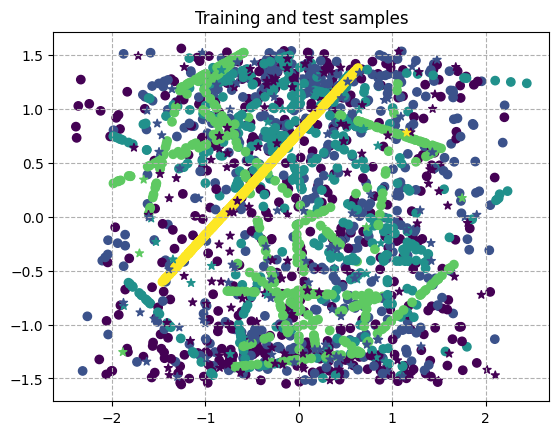

In [4]:
# select the first two features
X_train_reduced = X_train[:,2:4]
X_test_reduced = X_test[:,2:4]
print("Input shape reduced train: %s" %str(X_train_reduced.shape))
print("Input shape reduced test: %s" %str(X_test_reduced.shape))

plt.figure()
plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1], c=y_train)
plt.scatter(X_test_reduced[:,0], X_test_reduced[:,1], c=y_test, marker="*")
plt.grid(linestyle="--")
plt.title("Training and test samples")

In [5]:
print(np.unique(y_train))
p=np.divide(y.value_counts().to_numpy(),y.shape[0])
print(p)
gen_model = GaussianNB()
gen_model.fit(X_train_reduced, y_train)



[0 1 2 3 4]
[0.538 0.333 0.096 0.03  0.003]


GaussianNB()

In [14]:
y_pred = gen_model.predict(X_test_reduced)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
#0.553 with 0:2
#0.573 with 1:2
#0.580 with 2:4
#grid search to find best features


Accuracy 0.200


In [23]:
classifier=DecisionTreeClassifier(max_depth=14)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))


Accuracy 0.395
[0.53333333 0.30136986 0.16666667 0.1        0.        ]


Ensemble of kernelized methods and simple methods with BOOSTING (trying to improve Aaccuracy)


In [9]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=0.5):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class KernelPerceptron(object):

    def __init__(self, kernel=polynomial_kernel, T=1):
        self.kernel = kernel
        self.T = T

    def fit(self, X, y):
        n_samples, n_features = X.shape
        #np.hstack((X, np.ones((n_samples, 1))))
        self.alpha = np.zeros(n_samples, dtype=np.float64)

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        for t in range(self.T):
            for i in range(n_samples):
                if np.sign(np.sum(K[:,i] * self.alpha * y)) != y[i]:
                    self.alpha[i] += 1.0

        # Support vectors
        sv = self.alpha > 1e-5
        ind = np.arange(len(self.alpha))[sv]
        self.alpha = self.alpha[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]


    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return y_predict

    def predict(self, X):
        X = np.atleast_2d(X)
        n_samples, n_features = X.shape
        #np.hstack((X, np.ones((n_samples, 1))))
        return np.sign(self.project(X))


In [10]:
classifier=KernelPerceptron()
classifier.fit(X_train,y_train)
y_pred_train=classifier.predict(X_train)
print(accuracy_score(y_pred_train, y_train))  
print(sklearn.metrics.f1_score(y_train, y_pred_train,average=None))

0.15804195804195803
[0.         0.         0.29048843 0.         0.         0.        ]


In [22]:
classifier_name = 'D'
algorithm = 'SAMME.R' 
n_estimators=np.random.randint(5, 70, 5)

all_classifiers = {
    'G': [GaussianNB, 'Gaussian Naive Bayes'],
    #'P': [Perceptron(class_weight='balanced'), 'Perceptron'],
    'LR': [LogisticRegression, 'Logistic Regression'],
    'D': [DecisionTreeClassifier, 'Decision Tree'],
    'S': [svm.SVC, 'SVM']     
    }

#print(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=y))

boosting_params = {
  'learning_rate': np.random.uniform(size=5),
  'n_estimators': n_estimators,
  }

In [24]:

adaboost_classifier = AdaBoostClassifier(
    base_estimator=all_classifiers[classifier_name][0](max_depth=8),    #little less overfitting with max depth
    n_estimators=5, 
    learning_rate=0.2, 
    algorithm= algorithm, 
    random_state=random_state
    ).fit(X_train, y_train)

y_pred=adaboost_classifier.predict(X_test)
ada_accuracy_train = adaboost_classifier.score(X_train, y_train)  
ada_accuracy_test = adaboost_classifier.score(X_test,y_test)
print("Accuracy on train_set: %.3f" %ada_accuracy_train,"Accuracy on test_set: %.3f" %ada_accuracy_test)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))

Accuracy on train_set: 0.998 Accuracy on test_set: 0.427
[0.54166667 0.34394904 0.11764706 0.         0.        ]


In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
grid_search_boosting = GridSearchCV(
    adaboost_classifier,
    boosting_params, 
    scoring='accuracy', 
    cv=cv, 
    return_train_score=False,
    verbose=0
)
grid_search_boosting.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for boosting classifier: %r" %grid_search_boosting.best_params_)
print("Best accuracy: %.4f" %grid_search_boosting.best_score_)
print("Boosting Accuracy over the test set: %.4f" %grid_search_boosting.score(X_test, y_test))

Best classification hyper-parameters for boosting classifier: {'learning_rate': 0.1411639825937996, 'n_estimators': 5}
Best accuracy: 0.7646
Boosting Accuracy over the test set: 0.3818


Bagging

In [14]:
bagging_params = {
  'max_samples': np.random.randint(5,int(len(X_train)/2), 5),
  'n_estimators': n_estimators,
}
bagging_classifier = BaggingClassifier(
    base_estimator=all_classifiers[classifier_name][0](C=0.5,kernel='rbf', gamma='scale',class_weight='balanced'), 
    max_samples=744, 
    n_estimators=52,  
    random_state=random_state,
    ).fit(X_train, y_train)

y_pred=bagging_classifier.predict(X_test)
bagging_accuracy_test = bagging_classifier.score(X_test, y_test)
bagging_accuracy_train = bagging_classifier.score(X_train, y_train)  
print("Accuracy on train_set: %.3f" %bagging_accuracy_train,"Accuracy on test_set: %.3f" %bagging_accuracy_test)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))



Accuracy on train_set: 0.866 Accuracy on test_set: 0.427
[0.56451613 0.30985915 0.05263158 0.18181818 0.        ]


In [43]:
grid_search_bagging = GridSearchCV(
    bagging_classifier,
    bagging_params, 
    scoring='accuracy', 
    cv=cv, 
    return_train_score=False,
    # change max_features
    verbose=0
)
grid_search_bagging.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for bagging classifier: %r" %grid_search_bagging.best_params_)
print("Best accuracy: %.4f" %grid_search_bagging.best_score_)
print("Bagging Accuracy over the test set: %.4f" %grid_search_bagging.score(X_test, y_test))

Best classification hyper-parameters for bagging classifier: {'max_samples': 744, 'n_estimators': 52}
Best accuracy: 0.7967
Bagging Accuracy over the test set: 0.4227
